<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF- 477 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Andrea Freire - Francisco Sáez </H3>
<hr style="height:2px;border:none"/>


# 1. RNNs para series de tiempo

Las redes neuronales recurrentes (RNNs) son una red neuronal profunda que tiene, como su nombre indica, entradas recurrentes en la capa oculta, es decir, la salida de una capa oculta se retroalimenta a sí misma. La memoria neuronal es la capacidad impartida a un modelo para retener la entrada de los pasos de tiempo anteriores cuando la entrada es secuencial. En términos simples, cuando nuestro problema está asociado con una secuencia de datos como una oración o una serie temporal o la letra de una canción, el modelo tiene que recordar los estados previos de la entrada para funcionar.

<h1 align='center'> <img src="https://www.hobodataloggers.com.au/images/thumbs/0007371_hobo-weather-station-kits_510.jpeg" width="50%" height="100%" /> </h1>

En esta pregunta trabajaremos con datos obtenidos presumiblemente de una estación meteorológica, los cuales se obtienen desde el sitio https://www.kaggle.com/dronio/SolarEnergy, este dataset contiene mediciones de los últimos 4 meses. Nuestro objetivo será predecir el nivel de radiación solar para la próximas 24 horas.


## 1.a Carga de datos y preprocesamiento.

##### I) Iniciaremos cargando los datos. Para esto necesitará crear una cuenta en kaggle, dirigirse a su perfil, ir a Account, y en la sección API apretar _Create new API token_ , se descargará un archivo kaggle.json, ábralo como archivo de texto y obtenga su username y key. Luego ejecute el siguiente código (desconozco por qué pero a veces hay que ejecutar el código 2 veces para que funcione). Solución obtenida desde el hilo: https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27

In [2]:
username="asfreire"
key="f4f93e23360f63df65272541fdccefad"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d dronio/SolarEnergy
if not os.path.exists("/content/solar_prediction"):
    os.makedirs("/content/solar_prediction")
os.chdir('/content/solar_prediction')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

  0% 0.00/511k [00:00<?, ?B/s]
100% 511k/511k [00:00<00:00, 75.9MB/s]
SolarEnergy.zip  SolarPrediction.csv


Procederemos a ordenar la serie temporalmente a continuación.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu') # to convert unixtime
dataset = pd.read_csv('SolarPrediction.csv') # read data
dataset = dataset.sort_values(['UNIXTime'], ascending = [True]) #sort data
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s') # make unix pandas dataframe index
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii) # convert unixtime to timestamp
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet',"UNIXTime"], inplace=True, axis=1) # drop extra-time variables
dataset.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
UNIXTime,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25


**Comentario:** Se puede observar inmediatamente que existen datos faltantes, los cuales no son declarados. Dado que de los 6 datos impresos se puede inferir que el timestep es de 5 minutos, y faltarían los datos del instante 2016-09-01 ~00:10:00 y 2016-09-01 ~00:15:00

A continuación se proveen comandos con los cuales se puede observar cómo a partir del timestamp generado se puede categorizar con comandos simples el dataset según minuto del día, hora del día, mes del año, y día del año. Los cuales se ocuparán durante la tarea. 

In [4]:
dataset.index.minute,dataset.index.hour,dataset.index.month,dataset.index.dayofyear

(Int64Index([ 0,  5, 20, 25, 30, 45, 50, 55,  0,  5,
             ...
             10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
             ...
             23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([245, 245, 245, 245, 245, 245, 245, 245, 245, 245,
             ...
             366, 366, 366, 366, 366, 366, 366, 366, 366, 366],
            dtype='int64', name='UNIXTime', length=32686))

##### II) Para poder idententificar los Missing Values, y poder contar de manera segura con días de 24 horas, ejecute el siguiente código. **Explique** la funcionalidad del código escrito, escribiendo en forma de comentario (#) sobre las líneas de este código.

In [5]:
import time
#La funcion retorna el numero de segundos dados desde una fecha o timestamp dado. 
t1=time.time() 
#Completa una matriz de ceros con los valores  de las columnas y los valores de dias del año 
new_data=np.nan*np.zeros((24*12*(len(np.unique(dataset.index.dayofyear))),1+len(dataset.columns)), dtype=object)  
#Retorna los valores unicos de acuerdo al indice dado
days=np.unique(np.asarray([str(dataset.index[i]).split(" ")[0] for i in range(dataset.shape[0])]))

# Se da formato a los minutos
def min_to_str(min):
  #Se reemplaza con 00 cuando es 0
  if min==0: min="00" 
  #Se reemplaza con 0 concatenado con la variable de entrada, la cual es transformada a texto cuando es 5
  elif min==5: min="0"+str(min)
  #Se transforma la variable de entrada a texto
  else: min=str(min)
  return(min)

#Se itera
for i in range(new_data.shape[0]):
  #Transformar los segundos a horas
  hr=i//12-24*((i//12)//24)
  #Se reemplaza el valor de horas por el texto 00 si es igual a cero
  if hr==0: hr="00"
  #Si la hora esta entre 0 y 10 sin incluirlos se reemplaza por el valor del 0 concatenado por el valor del entero convertido a texto
  elif 0<hr<10: hr="0"+str(hr)
  #Si no es ninguna de las anteriores convierto la hora a texto
  else: hr=str(hr) 
  # Se calculan los minutos
  min=5*i-60*((5*i)//60)
  #Se calculan los dias
  day=(i//12)//24 
  #Se asigna los valores calculados en formato texto 
  new_data[i,0]=days[day]+" "+str(hr)+":"+min_to_str(min)+":00" 

# to see output
verbose,freq=True,12*24*5+12+1 
w_in=0

for i in range(dataset.shape[0]):
  #Se asigna cada casilla del dataset en la variable ind
  ind=dataset.index[i]
  # se extraen los minutos
  min=ind.minute
  #Si el indice es mayor que cero a la variable past_min se le asigna el valor del indice anterior. 
  if i>0: past_min=dataset.index[i-1].minute
  #Si el indice es menor que el tamaño del dataset entonces se le asigna el valor del indice siguiente 
  if i<dataset.shape[0]-1: next_min=dataset.index[i+1].minute
  #si el residuo de min con 5 es diferente de cero
  if min%5!=0:
    #Si la variable min mas 1 al calcular el residuo con 5 es 0 se suma 1 a la variable min
    if (min+1)%5==0: min=min+1
    #Si la variable min menos 1 al calcular el residuo con 5 es 0 se resta 1 a la variable min
    elif (min-1)%5==0: min=min-1
    #Si la variable past_min al calcular el residuo con 5 su valor es igual a cero 0
    elif past_min%5==0:
      #Si la variable past_min es diferente de 55 entonces se le suma 5 minutos a la variable min
      if past_min!=55: min=past_min+5
      #sino se le asigna cero
      else: min=0
      #si el residuo de next_min con 5 es igual a cero
    elif next_min%5==0:
      # Si next_min es diferente de cero entonces a min se le asigna past_min menos 5
      if next_min!=0: min=past_min-5
      #sino se le asigna 55
      else: min=55
      #Si la variable past_min-1 al calcular el residuo con 5 su valor es igual a cero 0
    elif (past_min-1)%5==0:
      #Si la variable past_min-1 es diferente de 55 entonces se le suma 5 minutos a la variable past_min-1 y se asigna a min
      if (past_min-1)!=55: min=past_min-1+5
      #sino se le asigna cero
      else: min=0
      #Sino se imprimen los valores de past_min,min,next_min
    else: print(past_min,min,next_min,"---keep expanding")
    #Se asigna los valores de indice y min en formato de texto.
  ind=str(ind)[:-11]+min_to_str(min)+str(ind)[-9:]
  #Se le asigna cero a la variable found
  found=0
  #print(w_in,w_in+new_data.shape[0])
  for w in range(w_in,w_in+new_data.shape[0]):
    #print(new_data[w,0][:])
    if new_data[w,0][:-2] in ind:
      w_in=w
      #print(w,i)
      found=1
      new_data[w,1:]=dataset.values[i,:]
      #print(new_data[w,0][:-2],verbose,i,w,freq,w_in,i+w)
      #se quito el +1 en la w del indice de new_data
      if verbose and i%freq==0: print(str(dataset.index[i]),"---->",new_data[w,0]);print(verbose,i,freq,w_in,i+w,new_data[w,0][:-2])
      break
  if found==0:
    print("Error at ",ind)
    break
#crea un nuevo dataset, asigna el index, cambia el tipo de dato afloat de 32 bits 
df=pd.DataFrame(new_data[:,1:].astype("float32"),index=new_data[:,0],columns=dataset.columns)
t2=time.time()
print("Time of computation (seconds): ", t2-t1)
print("N° Missing time steps data: ", np.isnan(new_data[:,1].astype("float")).sum())

2016-09-01 00:00:08-10:00 ----> 2016-09-01 00:00:00
True 0 1453 0 0 2016-09-01 00:00:
2016-09-06 07:05:20-10:00 ----> 2016-09-06 07:05:00
True 1453 1453 1525 2978 2016-09-06 07:05:
2016-09-13 02:25:08-10:00 ----> 2016-09-13 02:25:00
True 2906 1453 3485 6391 2016-09-13 02:25:
2016-09-19 03:20:05-10:00 ----> 2016-09-19 03:20:00
True 4359 1453 5224 9583 2016-09-19 03:20:
2016-09-24 06:30:19-10:00 ----> 2016-09-24 06:30:00
True 5812 1453 6702 12514 2016-09-24 06:30:
2016-09-29 11:15:22-10:00 ----> 2016-09-29 11:15:00
True 7265 1453 8199 15464 2016-09-29 11:15:
2016-10-05 14:35:20-10:00 ----> 2016-10-05 14:35:00
True 8718 1453 9679 18397 2016-10-05 14:35:
2016-10-10 18:25:23-10:00 ----> 2016-10-10 18:25:00
True 10171 1453 11165 21336 2016-10-10 18:25:
2016-10-15 21:50:21-10:00 ----> 2016-10-15 21:50:00
True 11624 1453 12646 24270 2016-10-15 21:50:
2016-10-20 23:50:20-10:00 ----> 2016-10-20 23:50:00
True 13077 1453 14110 27187 2016-10-20 23:50:
2016-10-26 01:25:17-10:00 ----> 2016-10-26 01:2

In [6]:
len(dataset.index)
print(len(new_data))
print(new_data[33983,0])
print(w)
print(df)
df.head()

33984
2016-12-31 23:55:00
33983
                     Radiation  Temperature  ...  WindDirection(Degrees)  Speed
2016-09-01 00:00:00       2.58         51.0  ...               77.269997  11.25
2016-09-01 00:05:00       2.83         51.0  ...              153.440002   9.00
2016-09-01 00:10:00        NaN          NaN  ...                     NaN    NaN
2016-09-01 00:15:00        NaN          NaN  ...                     NaN    NaN
2016-09-01 00:20:00       2.16         51.0  ...              142.039993   7.87
...                        ...          ...  ...                     ...    ...
2016-12-31 23:35:00       1.22         41.0  ...              238.940002   6.75
2016-12-31 23:40:00       1.21         41.0  ...              236.789993   5.62
2016-12-31 23:45:00       1.21         42.0  ...              218.279999   7.87
2016-12-31 23:50:00       1.19         41.0  ...              215.229996   7.87
2016-12-31 23:55:00       1.21         41.0  ...              215.559998   9.00

[33984 

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
2016-09-01 00:00:00,2.58,51.0,30.43,103.0,77.269997,11.25
2016-09-01 00:05:00,2.83,51.0,30.43,103.0,153.440002,9.00
2016-09-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:20:00,2.16,51.0,30.43,103.0,142.039993,7.87


##### III) **Reemplace** TODOS los missing values (NaN) de cada columna del nuevo dataset (df) de la forma que estime conveniente. Para esto debe usar los valores respectivos de cada columna, ya sea en el pasado o futuro. <br><br> _Como ejemplo_: Si es que existen datos perdidos a las 23:15 hrs, puede reemplazar el valor NaN con el promedio entre las 23:10 y 23:20, teniendo cuidado que el valor en la columna a reemplazar p.ej Pressure sea efectivamente el promedio entre la variable Pressure a las 23:10 y 23:20 . Note que el promedio entre un valor númerico y NaN es igual a NaN, por lo que tendrá que encontrar cómo hacer frente a esta situación.  <br><br> **Comente y fundamente su elección.**

In [7]:
time      = pd.to_datetime(df.index)
var_names = df.columns.tolist()
dat       = df.copy()
dat.interpolate(method='linear', inplace=True)
#data=df.copy().values
data=dat.copy().values
nan_row_loc=np.where((np.isnan((data[:,0]))==True))
np.isnan((data)).sum()
dat.interpolate(method='linear', inplace=True)
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
2016-09-01 00:00:00,2.58,51.0,30.43,103.0,77.269997,11.25
2016-09-01 00:05:00,2.83,51.0,30.43,103.0,153.440002,9.00
2016-09-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01 00:20:00,2.16,51.0,30.43,103.0,142.039993,7.87


In [8]:
dat.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
2016-09-01 00:00:00,2.580000,51.0,30.43,103.0,77.269997,11.250000
2016-09-01 00:05:00,2.830000,51.0,30.43,103.0,153.440002,9.000000
2016-09-01 00:10:00,2.606667,51.0,30.43,103.0,149.639999,8.623333
2016-09-01 00:15:00,2.383333,51.0,30.43,103.0,145.839996,8.246667
2016-09-01 00:20:00,2.160000,51.0,30.43,103.0,142.039993,7.870000


**Comentario:** En este caso se realizo la interpolacion lineal que permite rellenar mas de un espacio consecutivo de valores NaN. El cual traza una linea entre varios puntos y completa con valores intermedios entre los valores de inicio y de fin. La otra opcion era completar con el promedio de todos los valores de la columna para que no modifique pero realizando la interpolacion es como hacer pequeños promedios entre los valores al extremo de cada valor NaN.

**Para disminuir los tiempos de entrenamiento reduciremos la resolución temporal de 5-min a 1-hr. Para esto calcularemos el promedio de cada hora.**

In [9]:
data_hr=np.nan*np.zeros((int(data.shape[0]/12),data.shape[1]))
time_hr=np.nan*np.zeros((int(data.shape[0]/12)), dtype=object)

# Se promedian los datos para dejarlos en hora
for i in range(data_hr.shape[0]):
  data_hr[i,:]=np.mean(data[12*i:12*(i+1),:],axis=0)
  time_hr[i]=time[12*i]

# Se pasa el tiempo a hora
time_hr=pd.to_datetime(time_hr)

##### IV) **Separe** el dataset en conjuntos de entrenamiento, validación y test, para esto considere un 70% de los datos para entrenamiento, un 15% para validación y un 15% para test. Como se está trabajando con series de tiempo, proceda a crear los conjuntos de manera sucesiva. Guarde las fechas asociadas a cada dato puesto se utilizarán más adelante. 

In [10]:
# Cantidad de datos por conjunto
d70     = int(data_hr.shape[0]*0.7)
d15     = int(data_hr.shape[0]*0.15)
dtotal  = int(data_hr.shape[0])

# Se crean los conjuntos de trian, validation y test y se guarda el la fecha asociada a cada dato.
data_tr, time_tr    = data_hr[:d70],time_hr[:d70]
data_val, time_val  = data_hr[d70:d70+d15],time_hr[d70:d70+d15]
data_tst, time_tst  = data_hr[d70+d15:dtotal],time_hr[d70+d15:dtotal]

##### V) **Comente y visualice** los valores promedios y desviación estándar de cada atributo del dataset de entrenamiento según la hora del día y mes del año. Apóyese en el siguiente código si lo desea.

In [ ]:
time_tr

DatetimeIndex(['2016-09-01 00:00:00', '2016-09-01 01:00:00',
               '2016-09-01 02:00:00', '2016-09-01 03:00:00',
               '2016-09-01 04:00:00', '2016-09-01 05:00:00',
               '2016-09-01 06:00:00', '2016-09-01 07:00:00',
               '2016-09-01 08:00:00', '2016-09-01 09:00:00',
               ...
               '2016-11-23 04:00:00', '2016-11-23 05:00:00',
               '2016-11-23 06:00:00', '2016-11-23 07:00:00',
               '2016-11-23 08:00:00', '2016-11-23 09:00:00',
               '2016-11-23 10:00:00', '2016-11-23 11:00:00',
               '2016-11-23 12:00:00', '2016-11-23 13:00:00'],
              dtype='datetime64[ns]', length=1982, freq=None)

In [ ]:
data_tr[time_tr.month ==12]

array([], shape=(0, 6), dtype=float64)

Septiembre


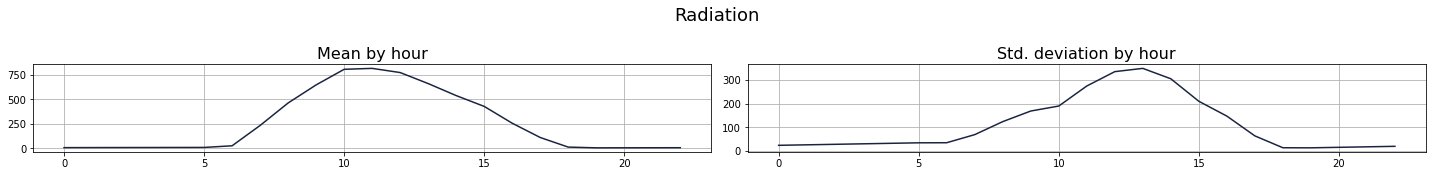

Octubre


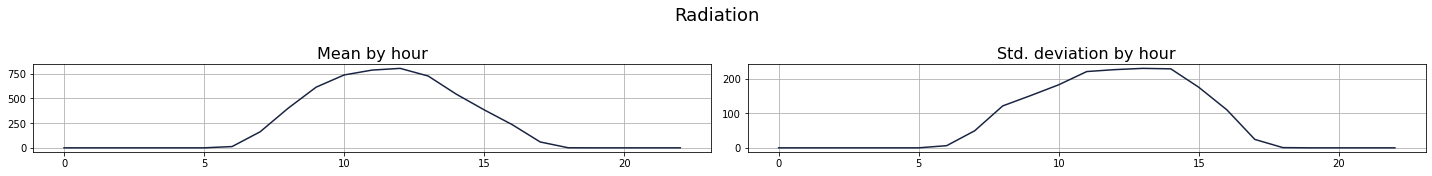

Noviembre


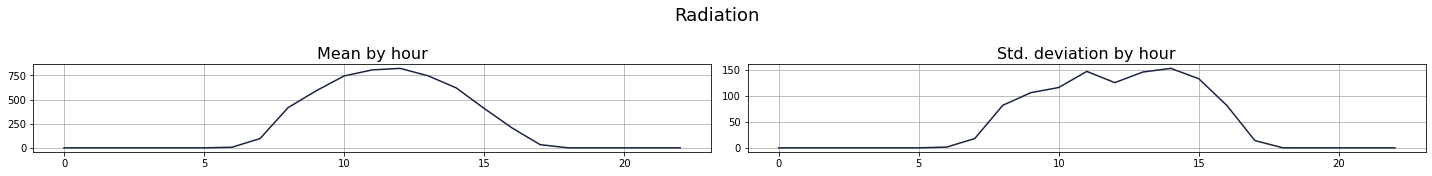

Septiembre


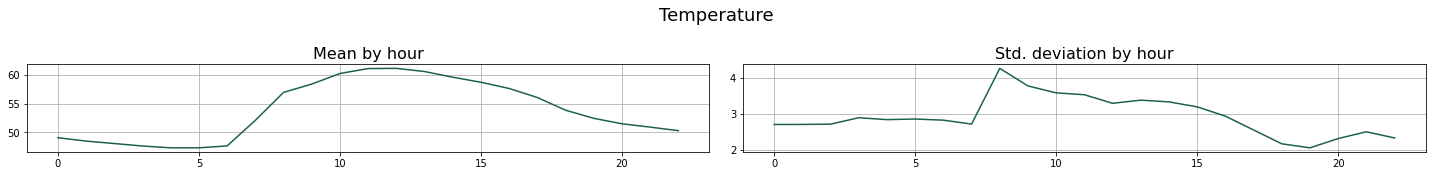

Octubre


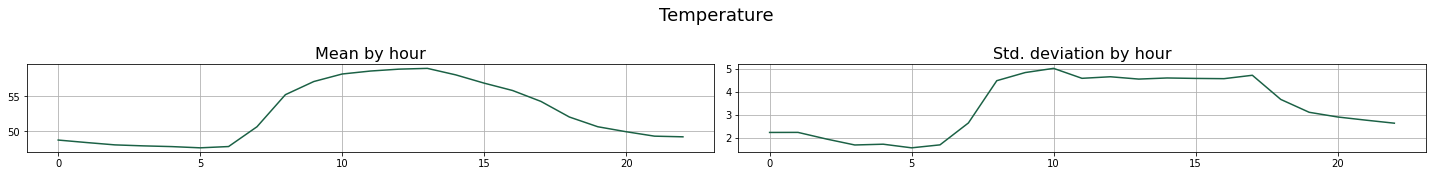

Noviembre


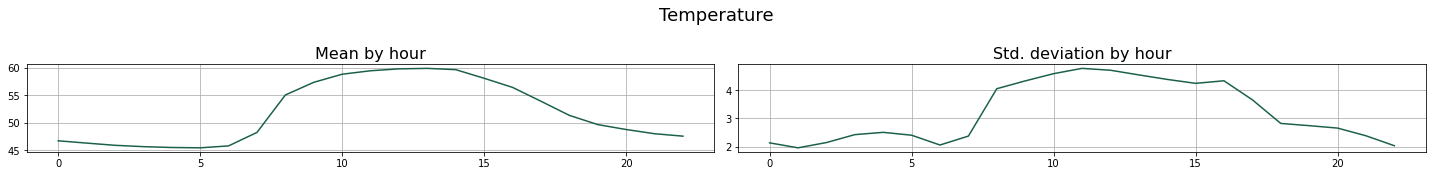

Septiembre


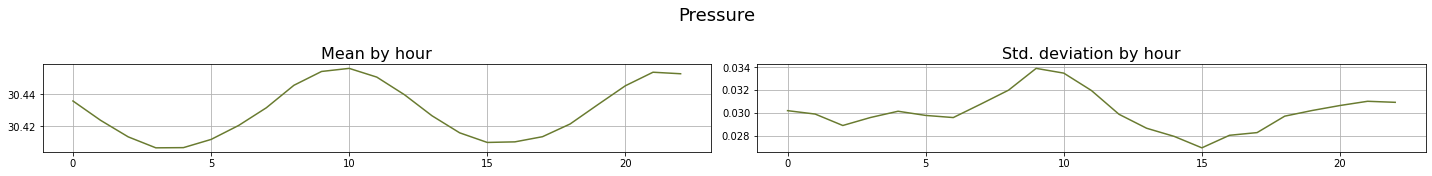

Octubre


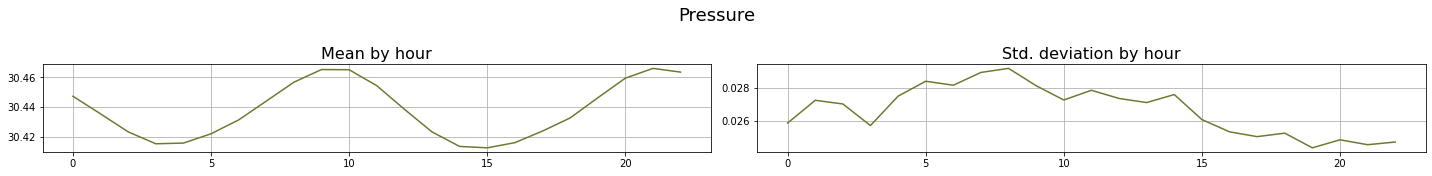

Noviembre


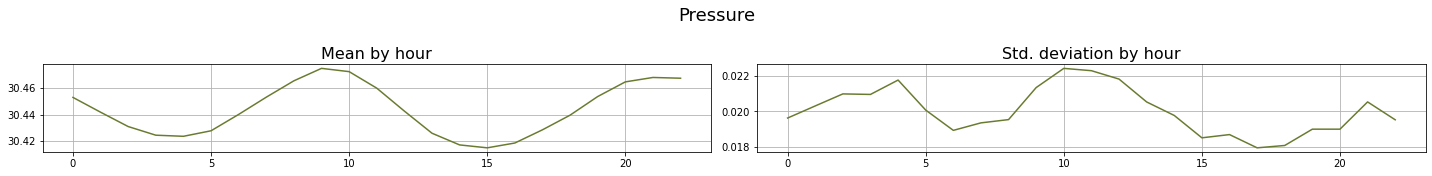

Septiembre


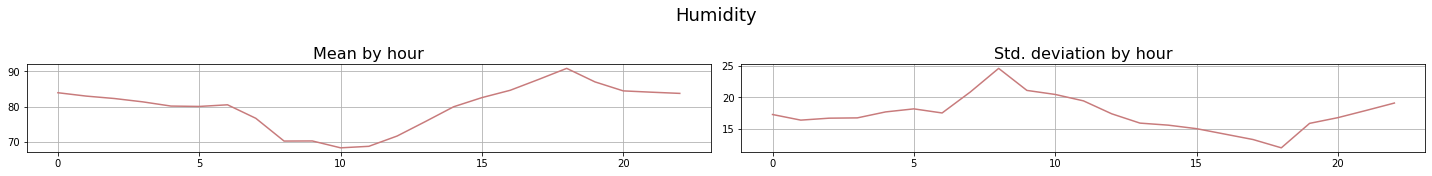

Octubre


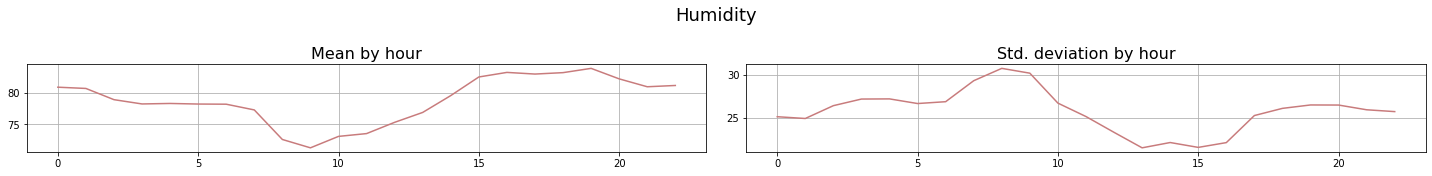

Noviembre


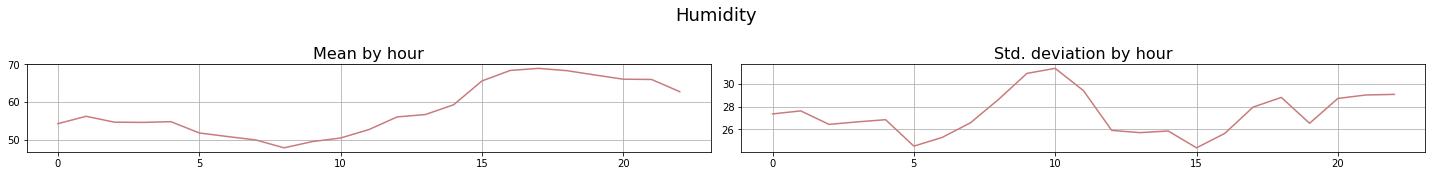

Septiembre


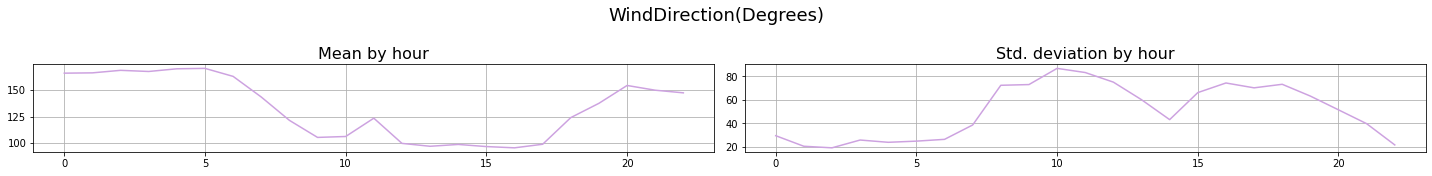

Octubre


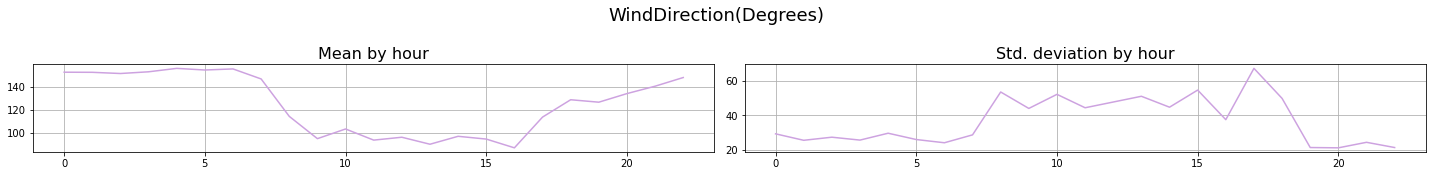

Noviembre


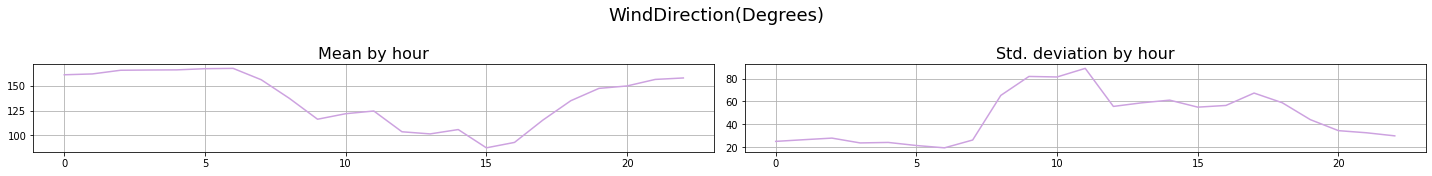

Septiembre


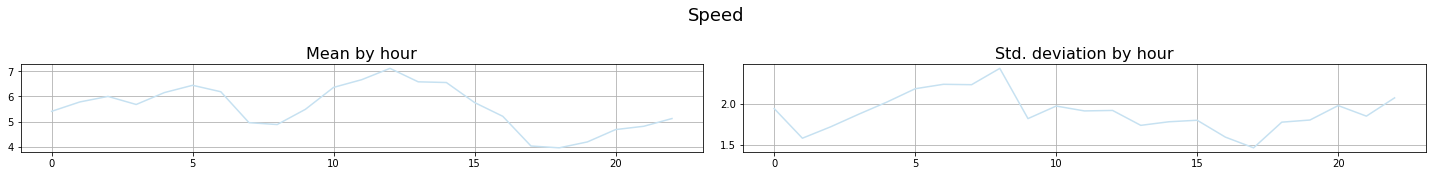

Octubre


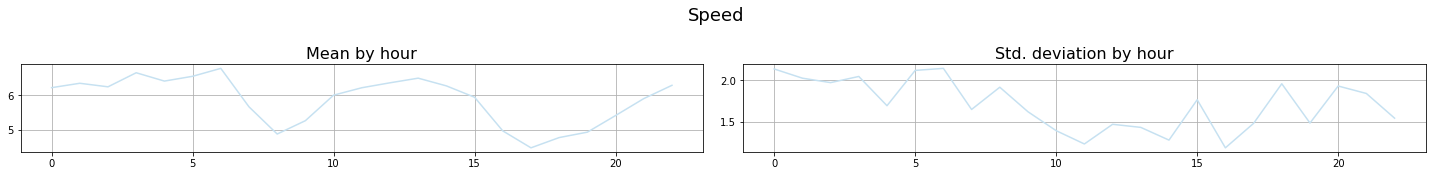

Noviembre


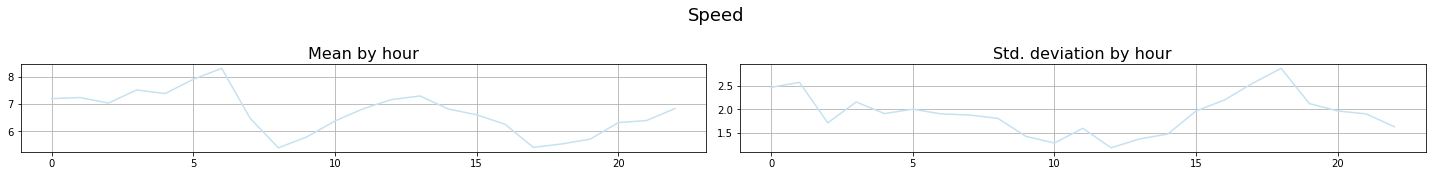

In [ ]:
import matplotlib.pyplot as plt
cols=sns.color_palette("cubehelix", len(var_names))
J=0
for J in range(len(var_names)):
  var_name=var_names[J]
  mean_per_hr=np.nan*np.zeros((24))
  std_per_hr=np.nan*np.zeros((24))
  for m in range(9,12):
    dm,tr = data_tr[time_tr.month ==m],time_tr[time_tr.month ==m]
    if m == 9:
      print('Septiembre')
    elif m==10:
      print('Octubre')
    elif m==11:
      print('Noviembre')  
    for hr in range(23):
      mean_per_hr[hr]=np.mean(dm[tr.hour==hr][:,J])
      std_per_hr[hr]=np.std(dm[tr.hour==hr][:,J])
    plt.rcParams["figure.figsize"]=[20,2]
    plt.suptitle(var_name,size=18,y=1.2)
    plt.subplot(1,2,1),plt.title("Mean by hour",size=16)
    plt.plot(mean_per_hr,color=cols[J]),plt.grid()
    plt.subplot(1,2,2),plt.title("Std. deviation by hour",size=16)
    plt.plot(std_per_hr,color=cols[J]),plt.grid()
    plt.tight_layout()
    plt.show()

**Comentario:** Se grafican solo los 3 primeros meses de la serie  porque parte del tercero y cuarto mes se toman como datos de test, los que se estan visualizando son los datos de entrenamiento. Se puede ver que la presion se la puede aproximar a una funcion trigonometrica como como el seno o el coseno. Tambien que tiene un periodo que es menor a las 24 horas del dia. Se puede ver que los valores maximos de radiacion se dan entre las 10 y 12:30 del dia para los tres meses que se muestran. Asi como existen valores maximos de radiacion tambien existe una variacion bastante significativa mientras se encuentran estos maximos y se extiende a lo largo del dia. La temperatura esta relacionada directamente con la radiacion. de acuerdo al grafico esta disminuye unas horas despues de haberse puesto el sol. Se puede ver que la desviacion estandar es menor aunque el grafico este escalado al mismo tamaño que los otros graficos. En cuanto a la presion se puede observar que desviacion estandar es mayor a medida que aumenta sus valores maximos. La presion esta realacionada con la temperatura en los maximos y minimos que son a medio dia y a media noche se ve que tiene sus maximos. La humedad esta realacionada de manera inversa con la radiacion y temperatura, a mayor temperatura y radiacion esta se presenta en sus minimos. Presenta variaciones mayores a lo que esta obteniendo sus valores minimos. Los valores en direccion del viento se muestran menores durante el dia pero aumentan durante la noche.Cuando obtiene sus valores minimos es cuando mas variacion se ve en la desviacion estandar. La velocidad del viento es mayor alrededor de la media noche y medio dia, la desviacion estandar es mayor durante todo el periodo.   

##### VI) **Estandarice** los conjuntos de entrenamiento, validación y test. Teniendo en mente que buscaremos predecir la radiación para las 24 horas futuras definiremos las variables de entrada y salida, realizando una transformación conveniente utilizando la función split_sequence entregada.

In [19]:
from sklearn.preprocessing import StandardScaler

# Se ajusta la data
scaler = StandardScaler()
scaler.fit(data_tr)

#Se transforma
xy_tr_sc=scaler.transform(data_tr)
xy_val_sc=scaler.transform(data_val)
xy_tst_sc=scaler.transform(data_tst)

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out,time_seq):
    X, y , seq_t= list(), list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0]
        seq_t.append(time_seq[end_ix])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) , np.asarray(seq_t)

In [21]:
len_inp=24
len_out=24

# Se divide la secuencia según la función anterior
x_tr,y_tr,t_tr=split_sequence(xy_tr_sc,len_inp,len_out,time_tr)
x_val,y_val,t_val=split_sequence(xy_val_sc,len_inp,len_out,time_tr)
x_tst,y_tst,t_tst=split_sequence(xy_tst_sc,len_inp,len_out,time_tr)

In [ ]:
x_tr[0]

array([[-7.11174580e-01, -2.63664678e-01, -2.24031086e-01,
         1.12308754e+00, -4.25781665e-01,  1.27862255e+00],
       [-7.09231601e-01, -1.93610310e-01, -6.08160950e-01,
         1.12308754e+00, -2.03854976e-01, -3.61612638e-01],
       [-7.09874161e-01, -2.77675295e-01, -1.01820829e+00,
         1.12308754e+00,  6.94763537e-02,  1.77895070e+00],
       [-7.11143981e-01, -3.05697171e-01, -1.14627113e+00,
         1.11040080e+00, -7.36728135e-01, -3.15263284e-01],
       [-7.10259186e-01, -5.99924621e-01, -9.15652479e-01,
         1.08502760e+00, -2.61582983e-01,  9.59238102e-01],
       [-7.12467347e-01, -6.27945856e-01, -7.87531009e-01,
         8.36052240e-01,  2.13395830e-01,  1.14159890e+00],
       [-6.40578452e-01, -6.20940868e-01, -6.97816661e-01,
         1.73174721e-01,  7.54520850e-02,  1.14200378e+00],
       [-3.28942182e-01, -4.03772774e-01, -1.98348155e-01,
         4.87169243e-01, -5.58619598e-01,  3.51383585e-03],
       [ 6.27563863e-01,  2.54153770e-03,  3.781

In [ ]:
y_tr[0]

array([-0.71133904, -0.70996341, -0.70992898, -0.71114908, -0.71096549,
       -0.71133522, -0.6464214 ,  0.19593066,  0.96961712,  1.6171985 ,
        2.1093404 ,  2.42182825,  2.51696054,  2.38860906,  2.08888205,
        1.19163037,  0.64035486,  0.03738422, -0.60522876, -0.70973647,
       -0.71015719, -0.71211547, -0.71111593, -0.70991751])

**Explique** a qué corresponde cada dimensión de las variables de entrada y salida.

In [ ]:
x_tr.shape,x_val.shape,x_tst.shape,y_tr.shape,y_val.shape,y_tst.shape

((1935, 24, 6), (377, 24, 6), (379, 24, 6), (1935, 24), (377, 24), (379, 24))

**Comentario:** En el caso de las x's el primer numero indica la cantidad de datos y tambien el dia, el 24 representa las 24 horas en las que esta dividido cada dato y el 6 es la cantidad de datos en esa hora que son las 6 columnas: Radiacion, temperatura, presion, humedad, wind degree y wind speed. Se encuentra en el formato de arreglo adentro de arreglo. En el caso de las y es la secuencia de predicion de las 24 horas siguientes dados los datos de x's.

## 1.b) Primera  red recurrente.
Ahora entrenaremos una primera red recurrente LSTM. **Explique** la particularidad de estas redes y **por qué** podría comportarse bien para este tipo de problemas. <br> <br> Entrenaremos dos redes recurrentes similares, la primera tan solo utilizará la variable Radiation como entrada para predecir Radiation, caso que llamaremos **univariante**, mientras la segunda utilizará las variables [Radiation, Temperature, Pressure, Humidity, WindDirection(Degrees), Speed] como entrada para predecir Radiation, caso que llamaremos **multivariante**. <br> <br> **Recupere** las funciones utilizadas en la tarea anterior para graficar los errores de entrenamiento, validación y test, y así comparar el rendimiento de ambas redes RNN gráficamente. **Comente**

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer

# Primer Modelo
# En este modelo recibe como input solo 1 variable
input_lstm  = input_layer.Input(shape=(x_tr.shape[1],1))
rnn         = layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens        = layers.Dense(len_out, activation='sigmoid')(rnn)
model_1     = models.Model(inputs=input_lstm, outputs=dens)
model_1.compile(loss='mse', optimizer='adam')

model_1.summary()
history_1   = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)

# Segundo Modelo
# Este modelo recibe como input 6 variables
input_lstm  = input_layer.Input(shape=(x_tr.shape[1:]))
rnn         = layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens        = layers.Dense(len_out, activation='sigmoid')(rnn)
model_2     = models.Model(inputs=input_lstm, outputs=dens)
model_2.compile(loss='mse', optimizer='adam')

model_2.summary()
history_2   = model_2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)

# Predicción del primer modelo
y_pred_1   = model_1(x_tst[:,:,0:1])
tst_loss_1 = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_1)).numpy()

# Predicción del segundo modelo
y_pred_2   = model_2(x_tst)
tst_loss_2 = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_2)).numpy()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 56)                12992     
_________________________________________________________________
dense (Dense)                (None, 24)                1368      
Total params: 14,360
Trainable params: 14,360
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 56)                14112     
________________________________________

In [ ]:
# Resultado de MSE del modelo 1 y 2 respectivamente sobre el test set.
print(tst_loss_1,tst_loss_2)

0.4500237 0.5164917


**Comentario:** La perdida que logra utilizando solo la radiacion es menor que utilizando todos los parametros. Le hace mas ruido. Probablemente necesite mas datos para funcionar mejor. De acuerdo a las observaciones la que mejor trabaja es la univariante. 

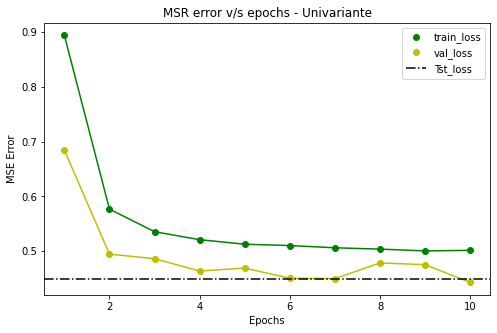

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
history_1.history
#hist.history['accuracy']
#hist.history['val_accuracy']
history_1.history['loss']
history_1.history['val_loss']
r = range(1,11,1)
plt.title('MSR error v/s epochs - Univariante')
plt.plot(r, history_1.history['loss'], 'go', label='train_loss')
plt.plot(r, history_1.history['val_loss'], 'yo', label='val_loss')
plt.plot(r, history_1.history['loss'], 'g')
plt.plot(r, history_1.history['val_loss'], 'y')
plt.axhline(y=tst_loss_1,color = 'k', linestyle = '-.', label = 'Tst_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Error')
plt.legend()
plt.show()

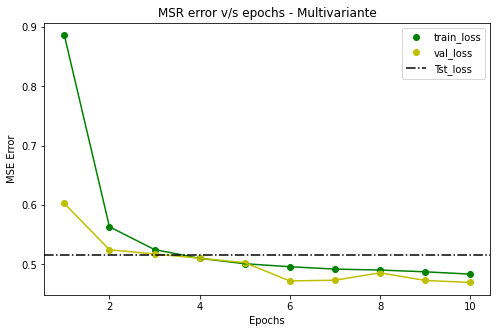

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
history_2.history
#hist.history['accuracy']
#hist.history['val_accuracy']
history_2.history['loss']
history_2.history['val_loss']
r = range(1,11,1)
plt.title('MSR error v/s epochs - Multivariante')
plt.plot(r, history_2.history['loss'], 'go', label='train_loss')
plt.plot(r, history_2.history['val_loss'], 'yo', label='val_loss')
plt.plot(r, history_2.history['loss'], 'g')
plt.plot(r, history_2.history['val_loss'], 'y')
plt.axhline(y=tst_loss_2,color = 'k', linestyle = '-.', label = 'Tst_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Error')
plt.legend()
plt.show()

**Explicacion:** Una LSTM se usa favorablemente para datos de series de tiempo ya que es capaz de "recordar" dependencias / información a largo plazo de una característica llamada **estado de celda**. Este estado de celda se ejecuta a través de las redes y transmite información de manera que la información anterior de una secuencia, por ejemplo, podría influir en la predicción de una entrada posterior. Este paso de información es crucial para las series de tiempo de los datos meteorológicos donde cada entrada depende de otra entrada de diferentes puntos de tiempo. La información que se almacena, elimina, modifica y transmite está controlada por puertas.

## 1.c) Exploración de profundidad y GRU.

##### I) Exploraremos aumentar la profundidad de la red neuronal. El modelo LSTM original se compone de una sola capa LSTM oculta seguida de una capa de salida estándar. Podríamos decir que nuestra red neuronal posee dos profundidades distintas. La Stacked LSTM es una extensión del modelo LSTM original, la cual tiene múltiples capas LSTM ocultas donde cada capa contiene múltiples celdas de memoria. A la vez, del mismo modo que en la Tarea 1, es posible aumentar la profundidad de la red densa de salida. 

Proceda a probar distintas combinaciones de profundidades de capas LSTM y de capas Densas (contando la capa de salida), para el caso univariado y multivariado. Para mantener un tiempo de ejecución produnte, considere una profunidad LSTM máxima de 2, y una profundidad densa máxima de 2. **Grafique y compare** los errores de entrenamiento, validación y test para los distintos casos.  **Comente**.

El siguiente código muestra el caso multivariado con profundidades máximas LSTM y Densas. Utilice el número de celdas de memoria y número de neuronas recomendado en el código para las distintas profundidades, al igual que el número de epochs.

**Pregunta:** ¿Por qué cuando una capa LSTM precede otra capa LSTM es necesario utilizar return_sequences=True? ¿Es necesario/recomendado utilizar return_sequences=False cuando una capa LSTM precede a una capa Densa?

**Respuesta:** En la primera respuesta es si se debe usar para pasar la secuencia a la siguiente capa LSTM. En la segunda pregunta tambien es recomendado porque pasa un valor que no sera necesario para la evaluacion en el caso de que la densa sea la capa final probablemente como capa intermedia no deberia haber problema.

In [ ]:
# Se crea modelo LSTM con mayor porfundidad
input_lstm = input_layer.Input(shape=(x_tr.shape[1:]))
rnn        = layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn        = layers.LSTM(units=56,return_sequences=False)(rnn)       # 2° lstm
dens       = layers.Dense(32, activation='relu')(rnn)                # 1° densa
dens       = layers.Dense(len_out, activation='sigmoid')(dens)       # 2° densa
model      = models.Model(inputs=input_lstm, outputs=dens)

# Compilación, ajuste y predicción
model.compile(loss='mse', optimizer='adam')
model.summary()
history_3   = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), 
                        epochs=10, batch_size=16, verbose=True)
y_pred_3    = model(x_tst)
tst_loss_3  = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_3)).numpy()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 56)            14112     
_________________________________________________________________
lstm_3 (LSTM)                (None, 56)                25312     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1824      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
Total params: 42,040
Trainable params: 42,040
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 26s 189ms/step - loss: 1.0411 - val_loss: 0.6199
Epoch 2/10
121/121

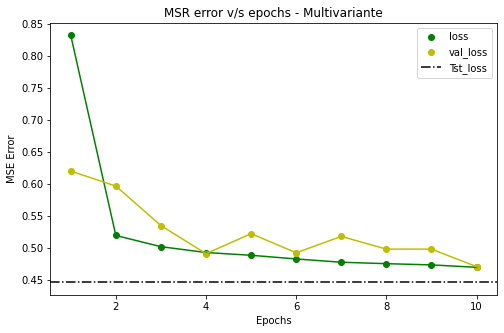

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
history_3.history
#hist.history['accuracy']
#hist.history['val_accuracy']
history_3.history['loss']
history_3.history['val_loss']
r = range(1,11,1)
plt.title('MSR error v/s epochs - Multivariante')
plt.plot(r, history_3.history['loss'], 'go', label='loss')
plt.plot(r, history_3.history['val_loss'], 'yo', label='val_loss')
plt.plot(r, history_3.history['loss'], 'g')
plt.plot(r, history_3.history['val_loss'], 'y')
plt.axhline(y=tst_loss_3,color = 'k', linestyle = '-.', label = 'Tst_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Error')
plt.legend()
plt.show()

In [ ]:
tst_loss_3

0.44591665

In [ ]:
# Se crea modelo LSTM con mayor porfundidad
input_lstm = input_layer.Input(shape=(x_tr.shape[1],1))
rnn        = layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn        = layers.LSTM(units=56,return_sequences=False)(rnn)       # 2° lstm
dens       = layers.Dense(32, activation='relu')(rnn)                # 1° densa
dens       = layers.Dense(len_out, activation='sigmoid')(dens)       # 2° densa
model      = models.Model(inputs=input_lstm, outputs=dens)

# Compilación, ajuste y predicción
model.compile(loss='mse', optimizer='adam')
model.summary()
history_3_1   = model.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), 
                        epochs=10, batch_size=16, verbose=True)
y_pred_3_1    = model(x_tst[:,:,0:1])
tst_loss_3_1  = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_3_1)).numpy()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 56)            12992     
_________________________________________________________________
lstm_5 (LSTM)                (None, 56)                25312     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1824      
_________________________________________________________________
dense_5 (Dense)              (None, 24)                792       
Total params: 40,920
Trainable params: 40,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 27s 190ms/step - loss: 1.0403 - val_loss: 0.5363
Epoch 2/10
121/121

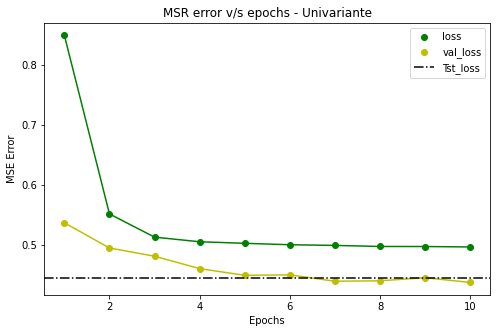

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
history_3_1.history
#hist.history['accuracy']
#hist.history['val_accuracy']
history_3_1.history['loss']
history_3_1.history['val_loss']
r = range(1,11,1)
plt.title('MSR error v/s epochs - Univariante')
plt.plot(r, history_3_1.history['loss'], 'go', label='loss')
plt.plot(r, history_3_1.history['val_loss'], 'yo', label='val_loss')
plt.plot(r, history_3_1.history['loss'], 'g')
plt.plot(r, history_3_1.history['val_loss'], 'y')
plt.axhline(y=tst_loss_3_1,color = 'k', linestyle = '-.', label = 'Tst_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Error')
plt.legend()
plt.show()

In [ ]:
tst_loss_3_1

0.4442505

**Comentarios:**Los resultados de la perdida en univariante siguen siendo menores que los de la red multivariante pero ambos resultados son menores que los del primer experimento. Para el caso de la multivariante tenemos que la perdida en el conjunto de entrenamiento es menor que la perdida en conjunto de validacion. En el conjunto de test es menor que el de entrenamiento y el de validacion. 

##### II) Añadiremos entradas a la capa Densa que indiquen la hora del día de forma bi-dimensional, semejante a un reloj, y una variable dummy que indica si es de día o noche. Ejecute el siguiente código para generar las entradas adicionales, y **añada la entrada** a la arquitectura entregada. Esta forma de ingresar variables adicionales a la capa densa se asemeja a la arquitectura skip-connections vista en la Tarea 1. **La hora que se entrega para indicar si es de día o noche es intencionalmente erronea**. Utilizando los datos de radiación del conjunto de entrenamiento **deberá definir las horas de día y noche de manera justificada**. 

**Comente** sobre los resultados obtenidos.

**Pregunta:** ¿Por qué puede resultar beneficioso representar la hora del día de manera bidimensional en lugar de unidimensional? 

**Respuesta:** Es beneficioso porque nos permite representar mas caracteristicas que aportan directamente al comportamiento del clima. Principalmente la radiacion que es producida por el sol y que solo se presenta mientras es de dia. Aparte que la hora en que aparece el sol y se oculta es tambien variable y no esta marcado a una hora en punto sino a las 6h30 y 18h30 por ejemplo en lugares donde no hay 4 estaciones y que no varia la salida y puesta del sol como Ecuador. Las series de tiempo tienen una componente periodica que se puede identificar mediante el analisis espectral. Lo que permite saber cada cuanto se repiten la serie.  

In [ ]:
daytimehrs=[6,18]

In [ ]:
from math import *
# Train set
hour_1_tr   = np.asarray(np.sin(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
hour_2_tr   = np.asarray(np.cos(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
dummy_tr    = (1*(pd.to_datetime(t_tr).hour<daytimehrs[1])*(pd.to_datetime(t_tr).hour>daytimehrs[0])).reshape(-1,1)

# Validation set
hour_1_val  = np.asarray(np.sin(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
hour_2_val  = np.asarray(np.cos(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
dummy_val   = (1*(pd.to_datetime(t_val).hour<daytimehrs[1])*(pd.to_datetime(t_val).hour>daytimehrs[0])).reshape(-1,1)

# Test set
hour_1_tst  = np.asarray(np.sin(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
hour_2_tst  = np.asarray(np.cos(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
dummy_tst   = (1*(pd.to_datetime(t_tst).hour<daytimehrs[1])*(pd.to_datetime(t_tst).hour>daytimehrs[0])).reshape(-1,1)

# Entrada para cada set
ext_tr      = np.concatenate((hour_1_tr,hour_2_tr,dummy_tr),axis=1)
ext_val     = np.concatenate((hour_1_val,hour_2_val,dummy_val),axis=1)
ext_tst     = np.concatenate((hour_1_tst,hour_2_tst,dummy_tst),axis=1)

In [ ]:
from keras.layers import concatenate

# Nuevo Modelo
input_lstm  = input_layer.Input(shape=(x_tr.shape[1],1))
rnn         = layers.LSTM(units=56,return_sequences=True)(input_lstm)  # 1° lstm
rnn         = layers.LSTM(units=56,return_sequences=False)(rnn)        # 2° lstm
input_clock = input_layer.Input(shape=(3))
input_dense = concatenate([rnn, input_clock])
dens        = layers.Dense(32, activation='relu')(input_dense)         # 1° densa
dens        = layers.Dense(len_out, activation='sigmoid')(dens)        # 2° densa
modelnew       = models.Model(inputs=[input_lstm,input_clock], outputs=dens)

# Compilar y ajustar
modelnew.compile(loss='mse', optimizer='adam')
modelnew.summary()
history_4   = modelnew.fit([x_tr[:,:,0:1],ext_tr],y_tr, validation_data=([x_val[:,:,0:1],ext_val],y_val), 
                        epochs=10, batch_size=16,verbose=True)
y_pred_4    = modelnew([x_tst[:,:,0:1],ext_tst])
tst_loss_4  = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_4)).numpy()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 24, 56)       12992       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 56)           25312       lstm_6[0][0]                     
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 3)]          0                                            
____________________________________________________________________________________________

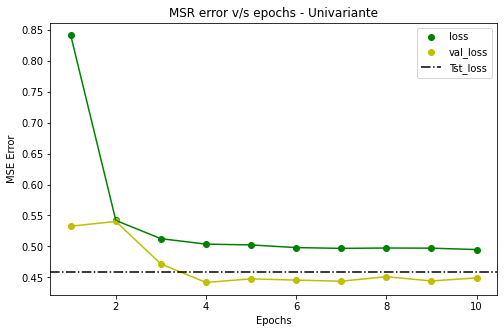

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
history_4.history
#hist.history['accuracy']
#hist.history['val_accuracy']
history_4.history['loss']
history_4.history['val_loss']
r = range(1,11,1)
plt.title('MSR error v/s epochs - Univariante')
plt.plot(r, history_4.history['loss'], 'go', label='loss')
plt.plot(r, history_4.history['val_loss'], 'yo', label='val_loss')
plt.plot(r, history_4.history['loss'], 'g')
plt.plot(r, history_4.history['val_loss'], 'y')
plt.axhline(y=tst_loss_4,color = 'k', linestyle = '-.', label = 'Tst_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Error')
plt.legend()
plt.show()

In [ ]:
tst_loss_4

0.45847583

**Comentario:**Los resultados son similares a la arquitectura anterior. Su desempeño es decente. El conjunto de entrenamiento tiene valores mayores de perdida mientras que en el conjunto de validacion se minimizan los valores. En el conjunto de test los valores estan por encima del conjunto de validacion y por debajo del conjunto de entrenamiento. 

##### III) Entrene la misma arquitectura que en la pregunta anterior utilizando unidades GRU en lugar de LSTM. **Explique la diferencia entre GRU y LSTM**. **Compare** los resultados con los obtenidos en el punto anterior.

**Respuesta:** La LSTM tiene mas compuertas que la GRU. La GRU tiene solo dos puertas (actualizar y restablecer), la LSTM tiene tres puertas (olvidar, entrada, salida).El GRU pasa directamente el estado oculto a la siguiente unidad, y el LSTM usa la celda de memoria para envolver el estado oculto.

In [ ]:
# Modelo con GRU

input_lstm  = input_layer.Input(shape=(x_tr.shape[1],1))
rnn         = layers.GRU(units=56,return_sequences=True)(input_lstm)   # 1° Capa GRU
rnn         = layers.GRU(units=56,return_sequences=False)(rnn)         # 2° Capa GRU
input_clock = input_layer.Input(shape=(3))
input_dense = concatenate([rnn, input_clock])
dens        = layers.Dense(32, activation='relu')(input_dense)         # 1° densa
dens        = layers.Dense(len_out, activation='sigmoid')(dens)        # 2° densa
modelgru    = models.Model(inputs=[input_lstm,input_clock], outputs=dens)

# Compilación y ajuste
modelgru.compile(loss='mse', optimizer='adam')
modelgru.summary()
history_5  = modelgru.fit([x_tr[:,:,0:1],ext_tr],y_tr, validation_data=([x_val[:,:,0:1],ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred_5   = modelgru([x_tst[:,:,0:1],ext_tst])
tst_loss_5 = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_5)).numpy()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 24, 56)       9744        input_7[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 56)           18984       gru[0][0]                        
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0                                            
____________________________________________________________________________________________

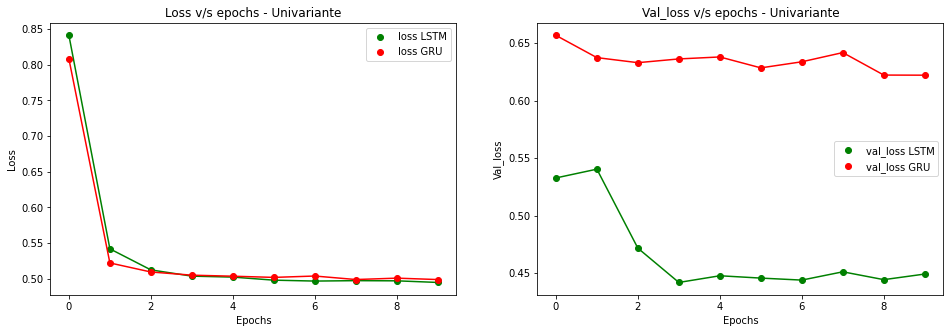

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,5]

plt.subplot(1,2,1)
plt.title('Loss v/s epochs - Univariante')
plt.plot(history_4.history['loss'], 'go', label='loss LSTM')
plt.plot(history_4.history['loss'], 'g')
plt.plot(history_5.history['loss'], 'ro', label='loss GRU')
plt.plot(history_5.history['loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.title('Val_loss v/s epochs - Univariante')
plt.plot(history_4.history['val_loss'], 'go', label='val_loss LSTM')
plt.plot(history_4.history['val_loss'], 'g')
plt.plot(history_5.history['val_loss'], 'ro', label='val_loss GRU')
plt.plot(history_5.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Val_loss')
plt.legend()
plt.show()

In [ ]:
tst_loss_5

0.46522507

**Comentario:**Se puede ver que la red LSTM realiza un mejor desempeño para esta tarea por los valores de perdida en el tst y en el conjunto de validacion. En la seccion de entrenamiento tiene un comportamiento similar. Las LSTM se demoran unos dos segundos mas en ejecutar cada epoch que la GRU.

##### IV) Con la red con mejor rendimiento, respecto al error de validación, en este punto 1.c) ejecute el siguiente código y saque conclusiones del violin plot.

**Pregunta:** ¿Qué hace un violin plot?

**Respuesta:** Un diagrama de violín se utiliza para visualizar la distribución de los datos y su densidad de probabilidad. Este gráfico posee un diagrama de densidad girado y colocado a cada lado, para mostrar la forma de distribución de los datos.  Es similar a los histograma de frecuencia pero la gráficas es una linea continua, que representa una función de densidad estimada

In [ ]:
print(tst_loss_1,tst_loss_2,tst_loss_3,tst_loss_3_1,tst_loss_4,tst_loss_5)


0.4500237 0.5164917 0.44591665 0.4442505 0.45847583 0.46522507


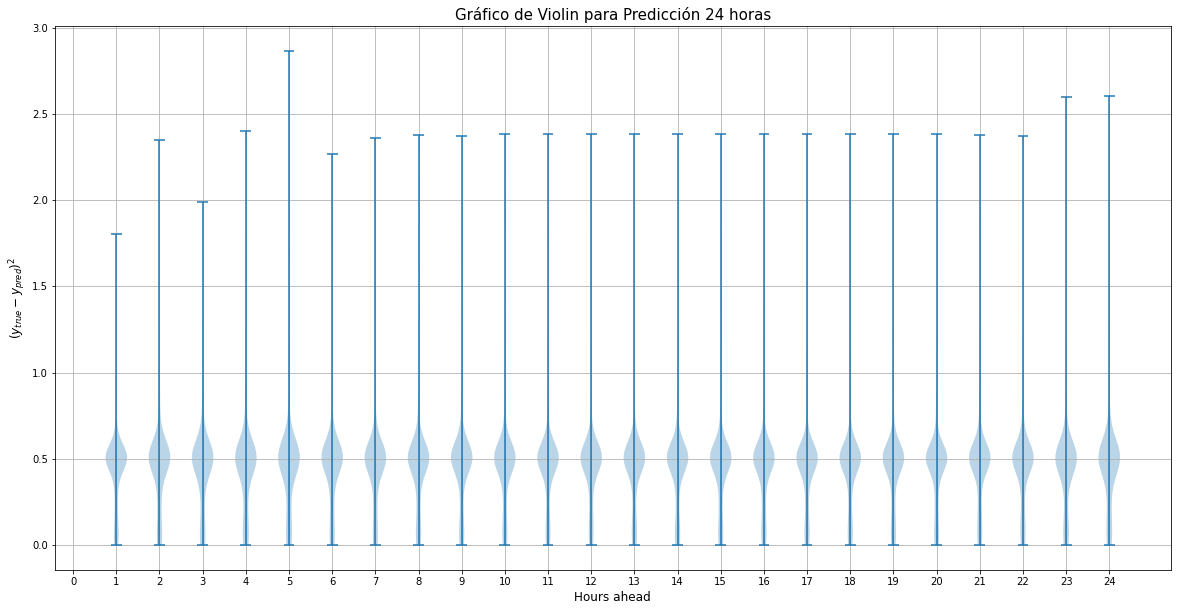

In [ ]:
#Con la 2da lstm
#y_pred=model(x_tst[:,:,0:1])
y_pred=modelnew([x_tst[:,:,0:1],ext_tst])
tst_loss=((y_tst- y_pred)**2).numpy()
plt.rcParams["figure.figsize"]=[20,10]
plt.title("Gráfico de Violin para Predicción 24 horas",size=15)
plt.violinplot(tst_loss)
plt.xlabel("Hours ahead",size=12)
plt.ylabel("$(y_{true}-y_{pred})^2$",size=12)
plt.xticks(np.arange(25))
plt.grid()
plt.show()

**Conclusion:** Representa la perdida de todo el conjunto de datos de test representado a nivel de horas, no toma en cuenta los dias sino lo que sucede a esa hora, por cada hora en un dia. Se ven los maximos y los minimos y donde se concentra la poblacion. Para este caso se concentra alrededor de 0.5. Los maximos se pueden ver que estan en un rango mayor a 1.5 y menor a 3.

## 1.d) Parameters & hyperparameters tunning. 

##### I) Como se habrá percatado, existe una **inmensa** cantidad de hiperparámetros que uno puede ajustar en las arquitecturas de redes neuronales (learning rate, profundidad de red, n° de neuronas en cada capa, optimizador, cantidad de epochs), también se puede considerar como hiperparámetro si es que incluir o no métodos tales como batch normalization, regularización L1/L2 o dropout en la red neuronal, a la vez habrá qué decidir dónde situar estos métodos, y cómo ajustar sus propios hiperparámetros. Aún más, también es posible experimentar con la manipulación del dataset, p.ej decidir si usar una entrada univariada, multivariada, o un punto intermedio (y si es un punto intermedio qué variables ocupar), también es posible variar el largo de las series de tiempo de entrada.

Prepare un código para hacer **Random Search**, dado que los tiempos de entrenamiento serán desproporcionados, **NO ENTRENE** las redes neuronales, pero evalúe en el conjunto de validación como si las hubiese entrenado para escoger los ""mejores"" parámetros & hiperparámetros de la red neuronal. Mantenga el objetivo de predecir la radiación para las siguientes 24 horas. **Imprima** (print) los valores de los parámetros & hiperparámetros de la red que se esté evaluando, indicando a qué corresponde, y recolecte el error de validación. Realice un Random Search de largo 100, apóyese en el código entregado, **expándalo** desde la búsqueda de 3 hiperparámetros/parámetros hasta una búsqueda de al menos **12** hiperparámetros/parámetros, puede escoger de los ejemplos dados en el primer párrafo de este ítem, o bien escoger por su propia cuenta. El código debe ser funcional, es decir, las _arquitecturas/manipulaciones del dataset_ indicadas por los hiperparámetros/parámetros deben ser efectivamente aplicadas en la construcción de la red neuronal y/o manipulación de datos. Note que en el código dado, un hiperparámetro a ajustar es recurrent dropout. **Indique** cuál fue la mejor arquitectura encontrada según el error de validación.

**Preguntas:** 

i) ¿Qué alternativas al Random Search existen? Nombre al menos una. 

ii) ¿Qué hace el método recurrent dropout?

i) Existe otra opcion que es Grid research la diferencia es que los parametros en esta configuracion son mas ordenados y se consume mas recursos porque se prueban todas las opciones y combinaciones de cada uno de los hiperparametros.
ii) Recurrent dropout es un método de regularización para redes neuronales recurrentes. El dropout se aplica a las actualizaciones de las celdas de memoria LSTM (o estados GRU), es decir, elimina la puerta de entrada / actualización en LSTM / GRU. El Recurrent dropout enmascara las conexiones entre las unidades recurrentes.

In [26]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from tensorflow.python.keras.layers import LSTM,GRU
from keras.regularizers import L1L2
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer
val_h      = []
params     = []
index = 0
val_min = 2.00
for random_search in range(100):
  # Profundidad aleatoría entre 1 y 4
  prof_rnn   = np.random.randint(1,4) 
  # Cantidad de neuronas por profundidad
  neu_rnn    = [np.random.randint(20,40) for t in range(prof_rnn)]
  # Recurrent Dropout aleatorio 
  rec_drop   = np.random.uniform(0,0.7)
  # Capas densa
  prof_dense = np.random.randint(1,3)
  # Cantidad de Neuronas de capa densa
  neu_dense  = [np.random.randint(20,40) for t in range(prof_dense)]
  # Función de activación
  activacion = ['sigmoid', 'tanh']
  activacion = [activacion[int(np.random.randint(0,2))] for t in range(prof_dense)]
  # Optimizador
  #optimizer  = ['adam', 'SGD']
  optimizer  = [SGD,Adam,RMSprop,Adagrad,Adadelta]
  optimizer  = optimizer[int(np.random.randint(0,5))]
  # Forma del input
  shape_in = np.random.randint(1,6) 
  # tipo de arquitectura
  ly = [LSTM,GRU]
  ly = ly[int(np.random.randint(0,2))]
  #learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
  learn_rate = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
  learn_rate = learn_rate[int(np.random.randint(0,6))]
  lear_decay = np.around(np.logspace(-6,0,6),decimals=6)
  lear_decay = lear_decay[int(np.random.randint(0,6))]
  regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
  reg = regularizers[int(np.random.randint(0,4))]

  input_lstm= input_layer.Input(shape=(x_tr.shape[1],shape_in))

  # Capa LSTM
  for i,neu in enumerate(neu_rnn):
    if i==0: 
      if len(neu_rnn) == 1:rs = False
      else: rs =True
      rnn=ly(units=neu_rnn[0], return_sequences=rs,recurrent_dropout=rec_drop,kernel_regularizer=reg)(input_lstm)
    else: rnn=ly(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop,kernel_regularizer=reg)(rnn)
  
  # Capas densa
  for i,neu in enumerate(neu_dense):
    if i == 0:
      dens = layers.Dense(neu, activation = activacion[i])(rnn)
    else:
      dens = layers.Dense(neu, activation = activacion[i])(dens)

  dens=layers.Dense(len_out, activation='sigmoid')(dens)
  
  # Modelo
  model=models.Model(inputs=input_lstm, outputs=dens)
  model.compile(loss='mse', optimizer=optimizer(learning_rate=learn_rate,decay=lear_decay))

  y_predd = 0
  y_predd = model(x_val[:,:,0:shape_in])

  val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_predd)).numpy()
  val_h.append(val_loss)
  
  if val_loss < val_min:
    val_min = val_loss
    index = random_search

  params.append([prof_rnn, neu_rnn, rec_drop, prof_dense, neu_dense, activacion, optimizer, shape_in,ly,learn_rate,lear_decay,reg])

  print(random_search+1,"° --->  Validation error: ",val_loss, '\n')
  print("-"*120)

1 ° --->  Validation error:  1.2223581 

------------------------------------------------------------------------------------------------------------------------
2 ° --->  Validation error:  1.133501 

------------------------------------------------------------------------------------------------------------------------
3 ° --->  Validation error:  1.1931901 

------------------------------------------------------------------------------------------------------------------------
4 ° --->  Validation error:  1.2065939 

------------------------------------------------------------------------------------------------------------------------
5 ° --->  Validation error:  1.138383 

------------------------------------------------------------------------------------------------------------------------
6 ° --->  Validation error:  1.1401125 

------------------------------------------------------------------------------------------------------------------------
7 ° --->  Validation error:  1

In [27]:
print("El index es:",index,", el error de validacion es: ",val_h[index],", los parametros son:",params[index])


El index es: 44 , el error de validacion es:  1.0972502 , los parametros son: [3, [37, 37, 21], 0.47907187304183113, 2, [28, 38], ['sigmoid', 'sigmoid'], <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'>, 5, <class 'tensorflow.python.keras.layers.recurrent.GRU'>, 0.001, 0.003981, <tensorflow.python.keras.regularizers.L1L2 object at 0x7ff3c94ffa20>]


##### II) Implemente sobre el código de Random Search la funcionalidad de realizar Cross-Validation con 5 Folds para cada red neuronal creada en el proceso de Random Search. Dado que se está trabajando con series de tiempo ocupe la función TimeSeriesSplit. Nuevamente **NO ENTRENE** las redes neuronales. El conjunto de entrenamiento y validación deben ser uno inicialmente para luego ser divididos en cada Fold, el conjunto de test se debiese mantener hasta el final. Calcule el error en el conjunto de validación de cada Fold y use el promedio de los 5 Folds para evaluar el rendimiento de cada red neuronal, encuentre los ""mejores"" parámetros/hiperparámetros basado en estos promedios.

**Preguntas:**

i) Visite la página https://scikit-learn.org/stable/modules/cross_validation.html . **Nombre y explique** el método TimeSeriesSplit y al menos otros 3 métodos de cross-validation. ¿Por qué time series split es adecuado para nuestro caso?

ii) ¿Cuáles son los fundamentos de Cross Validation en general (como herramienta de selección de hiperparámetros)?

In [11]:
from sklearn.model_selection import TimeSeriesSplit
data_tr_val, time_tr_val = data_hr[:int(data_hr.shape[0]*0.85)],time_hr[:int(data_hr.shape[0]*0.85)]   # DIVIDE IN EACH FOLD
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):]         # KEEP IT UNTIL THE END
# se debiese estandarizar en cada Fold ajustando el scaler con la data de entrenamiento que se genere

In [15]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

In [22]:
from sklearn.model_selection import KFold
loss_h      = []
params_f     = []
fold       =  TimeSeriesSplit(n_splits=5)
index      = 0
val_min    = 2.00

for random_search in range(100):
  # Profundidad aleatoría entre 1 y 4
  prof_rnn   = np.random.randint(1,4) 
  # Cantidad de neuronas por profundidad
  neu_rnn    = [np.random.randint(20,40) for t in range(prof_rnn)]
  # Recurrent Dropout aleatorio 
  rec_drop   = np.random.uniform(0,0.7)
  # Capas densa
  prof_dense = np.random.randint(1,3)
  # Cantidad de Neuronas de capa densa
  neu_dense  = [np.random.randint(20,40) for t in range(prof_dense)]
  # Función de activación
  activacion = ['sigmoid', 'tanh']
  activacion = [activacion[int(np.random.randint(0,2))] for t in range(prof_dense)]
  # Optimizador
  #optimizer  = ['adam', 'SGD']
  optimizer  = [SGD,Adam,RMSprop,Adagrad,Adadelta]
  optimizer  = optimizer[int(np.random.randint(0,5))]
  # Forma del input
  shape_in = np.random.randint(1,6) 
  # tipo de arquitectura
  ly = [LSTM,GRU]
  ly = ly[int(np.random.randint(0,2))]
  #learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
  learn_rate = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
  learn_rate = learn_rate[int(np.random.randint(0,6))]
  lear_decay = np.around(np.logspace(-6,0,6),decimals=6)
  lear_decay = lear_decay[int(np.random.randint(0,6))]
  regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
  reg = regularizers[int(np.random.randint(0,4))]


  # GENERAR MODELO 
  input_lstm= input_layer.Input(shape=(x_tr.shape[1],shape_in))

  # Capa LSTM
  for i,neu in enumerate(neu_rnn):
    if i==0: 
      if len(neu_rnn) == 1:rs = False
      else: rs =True
      rnn=ly(units=neu_rnn[0], return_sequences=rs,recurrent_dropout=rec_drop,kernel_regularizer=reg)(input_lstm)
    else: rnn=ly(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop,kernel_regularizer=reg)(rnn)
  
  # Capas densa
  for i,neu in enumerate(neu_dense):
    if i == 0:
      dens = layers.Dense(neu, activation = activacion[i])(rnn)
    else:
      dens = layers.Dense(neu, activation = activacion[i])(dens)
  dens=layers.Dense(len_out, activation='sigmoid')(dens)

  # Modelo
  model=models.Model(inputs=input_lstm, outputs=dens)
  model.compile(loss='mse', optimizer=optimizer(learning_rate=learn_rate,decay=lear_decay))

  # VALIDACIÓN EN KFOLD
  loss_fold = []
  for train_index, val_index in fold.split(data_tr_val):
    train_fold    = data_tr_val[train_index]
    val_fold      = data_tr_val[val_index]
    time_tr_fold  = time_tr_val[train_index]
    time_val_fold = time_tr_val[val_index]

    # Estandarizar 
    len_inp=24
    len_out=24

    # Se ajusta la data
    scaler = StandardScaler()
    scaler.fit(train_fold)

    #Se transforma
    xy_tr_sc=scaler.transform(train_fold)
    xy_val_sc=scaler.transform(val_fold)

    # Se divide la secuencia según la función anterior
    x_tr,y_tr,t_tr=split_sequence(xy_tr_sc,len_inp,len_out,time_tr_fold)
    x_val,y_val,t_val=split_sequence(xy_val_sc,len_inp,len_out,time_val_fold)
    
    # CALCULO DE LOSS x FOLD
    y_predd = 0
    y_predd = model(x_val[:,:,0:shape_in])

    val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_predd)).numpy()
    loss_fold.append(val_loss)
  val = np.mean(loss_fold)
  loss_h.append(val)

  params_f.append([prof_rnn, neu_rnn, rec_drop, prof_dense, neu_dense, activacion, optimizer, shape_in,ly,learn_rate,lear_decay,reg])

  print(random_search+1,"° --->  Validation error: ",val, '\n')
  print("-"*120)


1 ° --->  Validation error:  1.2496679 

------------------------------------------------------------------------------------------------------------------------
2 ° --->  Validation error:  1.2512257 

------------------------------------------------------------------------------------------------------------------------
3 ° --->  Validation error:  1.2475852 

------------------------------------------------------------------------------------------------------------------------
4 ° --->  Validation error:  1.2063153 

------------------------------------------------------------------------------------------------------------------------
5 ° --->  Validation error:  1.258246 

------------------------------------------------------------------------------------------------------------------------
6 ° --->  Validation error:  1.2351323 

------------------------------------------------------------------------------------------------------------------------
7 ° --->  Validation error:  

In [28]:
import numpy as np
loss_hm = np.array(loss_h)
ranking = loss_hm.argsort()[:5]
for i,value in enumerate(ranking, start=0):
  print(i,value)
  print("El puesto No :", i+1," es el index es:",value,", el error de validacion es: ",loss_hm[value],", los parametros son:",params[value])

0 10
El puesto No : 1  es el index es: 10 , el error de validacion es:  1.2025257 , los parametros son: [1, [21], 0.6503609144417966, 1, [23], ['sigmoid'], <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'>, 3, <class 'tensorflow.python.keras.layers.recurrent.LSTM'>, 0.1, 0.063096, <tensorflow.python.keras.regularizers.L1L2 object at 0x7ff431e3c048>]
1 3
El puesto No : 2  es el index es: 3 , el error de validacion es:  1.2063153 , los parametros son: [1, [30], 0.03836215157927822, 2, [39, 34], ['tanh', 'sigmoid'], <class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>, 1, <class 'tensorflow.python.keras.layers.recurrent.GRU'>, 0.01, 0.003981, <tensorflow.python.keras.regularizers.L1L2 object at 0x7ff431e5b240>]
2 40
El puesto No : 3  es el index es: 40 , el error de validacion es:  1.2126303 , los parametros son: [2, [32, 39], 0.4807669109759083, 1, [24], ['sigmoid'], <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 3, <class 'tensorflow.python

i)TimeSeriesSplit es un metodo que sirve de manera analoga al cross validation pero para series de tiempo. La principal diferencia es que los grupos en los que se dividen los datos no es que son del todo distintos. Sino que son por ejemplo el conjunto 1 es solo un grupo pequeño, el grupo 2 es la union del grupo 1 con el grupo 2 y en el grupo 3 se juntan los 3 grupos.  
KFold divide todas las muestras en grupos de muestras, llamados folds  de igual o similar tamaño . La función de predicción se aprende usando los folds , y el fold que se deja fuera se usa para la prueba. Es similar a la estrategia Leave One Out.

StratifiedKFold es una variación de k-fold que devuelve folds estratificados: cada conjunto contiene aproximadamente el mismo porcentaje de muestras de cada clase de destino que el conjunto completo.

LeaveOneOut (o LOO) es una simple validación cruzada. Cada conjunto de aprendizaje se crea tomando todas las muestras excepto una, siendo el conjunto de prueba la muestra omitida. Por lo tanto, para las muestras, tenemos diferentes conjuntos de entrenamiento y diferentes conjuntos de pruebas. Este procedimiento de validación cruzada no desperdicia muchos datos ya que solo se elimina una muestra del conjunto de entrenamiento.

ii)La validación cruzada o cross-validation es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes los conjuntos de datos de entrenamiento y prueba. Consiste en repetir y calcular la media aritmética(el promedio) obtenida de las medidas de evaluación sobre diferentes particiones. Se utiliza en entornos donde el objetivo principal es la predicción y se quiere estimar la precisión de un modelo que se llevará a cabo a la práctica